In [1]:
! pip install --quiet gensim

You are using pip version 19.0.3, however version 19.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [1]:
import pandas as pd
import re

yelps = pd.read_csv('sentiment/yelps.csv').sample(frac=1).reset_index(drop=True)

In [2]:
from bs4 import BeautifulSoup

def clean_yelp(s):
    s = BeautifulSoup(s, 'html5lib').get_text()
    s = ' '.join(s.split())
    s = s.strip().lower()
    return s

In [3]:
def tokenize(s):
    """ Returns a list of strings (tokens) from the document """
    t = r'(?u)\b\w+\b'
    t = re.compile(t)
    return t.findall(s)

    # Implement this function!
    # Hint: If you look at the sklearn source code on github, 
    # you will find a good regular expression they use as a default
    # tokenizer in CountVectorizer -- this is the tokenizer
    # we have been using until now!
    # But you need to implement your own now. 
    pass

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD

# Create a count vectorizer, using the preprocessor and tokenizer from above
vectorizer = CountVectorizer(preprocessor = clean_yelp, tokenizer = tokenize)
V = vectorizer.fit_transform(yelps.text)
# use TruncatedSVD from Sklearn to generate a term embedding matrix for your data
# that is 100 dimensional in size.
svd = TruncatedSVD(n_components=100)
SVD = svd.fit_transform(V)  

# Embed your documents via that term embedding matrix (this is just the PCA of the 
# TF matrix, as returned by "transform" on TruncatedSVD

# Here you should have TWO vector representations of your Yelp data: 
# 1. The original TF matrix
# 2. The first 100 components of the PCA of that matrix, as performed by TruncatedSVD

/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:282: UserWarning: "https://www.consumeraffairs.com/news/mypillow-gets-a-rude-awakening-as-the-better-business-bureau-gives-it-an-f-010517.html" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:219: UserWarning: "b'..'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)


In [5]:
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

def test_holdout_vectors(V, y, cutoff):
    model = LogisticRegression()
    model.fit(V[:cutoff], y[:cutoff])
    preds = model.predict(V[cutoff:])
    return accuracy_score(preds, y[cutoff:])

In [6]:
# Test your vector representations using the above function, test_holdout_vectors. 
# for several levels of "cutoff". 
c = [100, 1500, 5000, 10000, 50000]
for i in c:
    print("cut:", i, "accuracy 100 dimensions:", round(test_holdout_vectors(SVD, yelps.positive, i),3))

for i in c:
    print("cut:", i, "accuracy Full:", round(test_holdout_vectors(V, yelps.positive, i),3))

# This function simulates training on a small part of your data and testing on the rest.
# Thus, it's as though you have some labelled data but a bunch of unlabelled data. 
# This is essentially a semi-supervised situation. 

# Do the word embeddings generated via SVD allow you to pull information from the 
# unlabeled data and improve your score given a small training set? 

cut: 100 accuracy 100 dimensions: 0.773
cut: 1500 accuracy 100 dimensions: 0.872
cut: 5000 accuracy 100 dimensions: 0.887
cut: 10000 accuracy 100 dimensions: 0.89
cut: 50000 accuracy 100 dimensions: 0.892
cut: 100 accuracy Full: 0.801
cut: 1500 accuracy Full: 0.919
cut: 5000 accuracy Full: 0.939
cut: 10000 accuracy Full: 0.948
cut: 50000 accuracy Full: 0.959


In [7]:
import multiprocessing
cores = multiprocessing.cpu_count()
sentences = pd.Series([])
for val in yelps.text:
    sentences = sentences.append(pd.Series([tokenize(clean_yelp(val))]))


from gensim.models import Word2Vec

# Next, create another term embedding via Word2Vec, also 100 dimensional
# Look at the documentation from the library gensim and see what hyperparameters
# you can choose to tune. 
# Note: training takes time, so you probably won't want to try too many!


# pass the cleaned and tokenized yelp reviews as "sentences" to your model
# to build the vocabulary and train the word vectors. 

/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:282: UserWarning: "https://www.consumeraffairs.com/news/mypillow-gets-a-rude-awakening-as-the-better-business-bureau-gives-it-an-f-010517.html" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:219: UserWarning: "b'..'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
/anaconda3/lib/python3.6/site-packages/smart_open/ssh.py:34: UserWarning: paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress
  warnings.warn('paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress')


In [8]:
w2v = Word2Vec(size=150, window=2, alpha=0.02, 
               min_alpha=0.0006, workers= cores-1)


w2v.build_vocab(sentences)
w2v.train(sentences, total_examples=w2v.corpus_count, epochs=30)

(268369450, 362492790)

In [9]:
# use the embed_w2v function to embed your Yelp reviews using the new
# word2vec word embeddings. Each review will be a normalized sum of the
# words that it is made of. 
# See how this improves the scores in the classification task using
# test_holdout_vectors -- is word2vec better? At what training-set sizes does it help
# more? 

In [10]:
import numpy as np

def embed_w2v(tokens, w2v):
    idxs = [w2v.wv.vocab.get(t) for t in tokens]
    idxs = [t.index for t in idxs if t]
    N = w2v.wv.vectors.shape[1]
    if len(idxs) < 1:
        return np.zeros(N)
    a = np.sum(w2v.wv.vectors[idxs, :], axis=0)
    a /= np.linalg.norm(a)
    return a


# use as follows: np.array([embed_w2v(t, w2v) for t in X])


c = [100, 1500, 5000, 10000, 50000]
for i in c:
    print("cut:", i, "accuracy 100 dimensions:", round(test_holdout_vectors(SVD, yelps.positive, i),3))

for i in c:
    print("cut:", i, "accuracy Full:", round(test_holdout_vectors(V, yelps.positive, i),3))

for i in c:
    print("cut:", i, "accuracy w2v:", round(test_holdout_vectors(np.array([embed_w2v(t, w2v) for t in sentences]), yelps.positive, i),3))



cut: 100 accuracy 100 dimensions: 0.773
cut: 1500 accuracy 100 dimensions: 0.872
cut: 5000 accuracy 100 dimensions: 0.887
cut: 10000 accuracy 100 dimensions: 0.89
cut: 50000 accuracy 100 dimensions: 0.892
cut: 100 accuracy Full: 0.801
cut: 1500 accuracy Full: 0.919
cut: 5000 accuracy Full: 0.939
cut: 10000 accuracy Full: 0.948
cut: 50000 accuracy Full: 0.959
cut: 100 accuracy w2v: 0.818
cut: 1500 accuracy w2v: 0.909
cut: 5000 accuracy w2v: 0.932
cut: 10000 accuracy w2v: 0.939
cut: 50000 accuracy w2v: 0.947


Depending on the parameters w2v performes better or worst. In this case it performes better than the other two models

In [11]:
import pandas as pd
import re
import spacy
from functools import reduce

nlp = spacy.load("en")
pats = [re.compile(r'https?:\/\/[^\s]+'), 
        re.compile(r'rt\s*@\w+\s?:?'),
        re.compile(r'@\w+')]

def clean_twitter(s):
    """ Cleans Twitter specific issues
    
    Should probably clean out mentions, URLs, and RT's.
    """
    s = re.sub('RT @[\w]*:|RT @[\w]*=:', '', str(s)) # remove RT's
    s = re.sub('(@[A-Za-z]+[A-Za-z0-9-_]+)', '', str(s)) # remove mentions
    s = re.sub(r'http\S+', '', str(s)) # remove http links
    s = re.sub(r'[:;,.\'""!\s]',' ', str(s)) # remove special caracters
    doc = nlp(s) # using spacy
    s = ' '.join([token.lemma_ for token in doc]) #lemmatizing
   
    s = s.lower()
    _sub = lambda s,pat: re.sub(pat, '', s)
    s = reduce(_sub, pats, s)
    s = ' '.join(s.split()).strip()
    # TODO: Use regular expressions to remove unwanted
    # text and clean up our tweets to be more usable!

    # BONUS: Try using the library "spacy" to 
    # do further processing, such as lemmatizing
    # or replacing Named Entities with constants (i.e. "[NAMED]")
    # or adding the part of speech or dependency code to the word 

    return s

In [12]:
# Load tweet!
# NOTE: this file needs to be downloaded from Box! 

with open('tweets/tweets.txt') as f:
    tweets = pd.Series(f.readlines())
    
tweets2 = tweets.sample(10000)

In [13]:
vectorizert = CountVectorizer(preprocessor = clean_twitter)
Vt = vectorizert.fit_transform(tweets2)
# use TruncatedSVD from Sklearn to generate a term embedding matrix for your data
# that is 100 dimensional in size.
svdt = TruncatedSVD(n_components=100)
SVDt = svd.fit_transform(Vt) 

In [14]:
sentences_t= [clean_twitter(val).split(' ') for val in tweets2]
w2v_t = Word2Vec(sentences_t, workers=5)
w2v_twitter = np.array([embed_w2v(val, w2v_t) for val in sentences_t])

In [15]:
# Now embed this twitter data, again using Word2Vec and LSA (SVD)
# you don't have any labels, but you might be able to 
# find some interesting phenomena. 

# Explore using either or both of the following tools: 
# 1. Word2Vec has a built in feature for getting most similar
# words, including via positive/negative examples (subtraction)
# What happens when you subtract "hillary" from "trump"? 

# Bonus: build a similar feature for your LSA features and
# see if you can do similar vector math

# 2. Use the visualize_dist function to see how
# the tweet-tweet distance looks for a selection
# of random tweets. Do you agree with the distance? 
# Does one embedding seem better than another? 

In [16]:
w2v_t.wv.most_similar('trump')

[('president', 0.9855932593345642),
 ('hillary', 0.979468822479248),
 ('donald', 0.9792205691337585),
 ('’s', 0.973223865032196),
 ('an', 0.9718804359436035),
 ('the', 0.9715105891227722),
 ('agree', 0.9700748324394226),
 ('good', 0.9699569344520569),
 ('win', 0.9696658253669739),
 ('man', 0.9678012132644653)]

In [17]:
w2v_t.wv.most_similar('hillary')

[('clinton', 0.9876598119735718),
 ('the', 0.9824522733688354),
 ('trump', 0.979468822479248),
 ('obama', 0.9774444699287415),
 ('an', 0.9765650033950806),
 ('’s', 0.9758151769638062),
 ('man', 0.9745132327079773),
 ('to', 0.9742404222488403),
 ('of', 0.9741161465644836),
 ('with', 0.972431480884552)]

In [18]:
w2v_t.wv.most_similar(positive=['hillary'], negative=['trump'])

[('today', 0.21320399641990662),
 ('on', 0.19698399305343628),
 ('islamophobia', 0.18397989869117737),
 ('u', 0.16512557864189148),
 ('s', 0.15675951540470123),
 ('-', 0.13721688091754913),
 ('islam', 0.13624869287014008),
 ('lesson', 0.13417547941207886),
 ('muslimsarebeautiful', 0.13059578835964203),
 ('enlist', 0.12727665901184082)]

In [19]:
w2v_t.wv.most_similar(positive=['trump'], negative=['hillary'])

[('🇸', 0.7297031283378601),
 ('🇺', 0.7235629558563232),
 ('🌟', 0.6665850281715393),
 ('❤', 0.5398600101470947),
 ('🚂', 0.5105487704277039),
 ('🇷', 0.49803945422172546),
 ('☑', 0.49380365014076233),
 ('fboloud', 0.49059656262397766),
 ('presidenttrump', 0.4627569913864136),
 ('🙏', 0.44616925716400146)]

In [20]:
from scipy.spatial.distance import pdist,squareform
import seaborn as sns

def visualize_dist(V, tweets, idxs):
    """ Visualize distances in heatmap

    V is the vector of embeddings 
    tweets is a list or series that converts from idx to tweet
    idxs is a list of integers that you would like to compare (<= 5 probably)
    """
    m = squareform(pdist(V[idxs], 'cosine'))
    _ = sns.heatmap(pd.DataFrame(m, columns = tweets[idxs], index= tweets[idxs]))

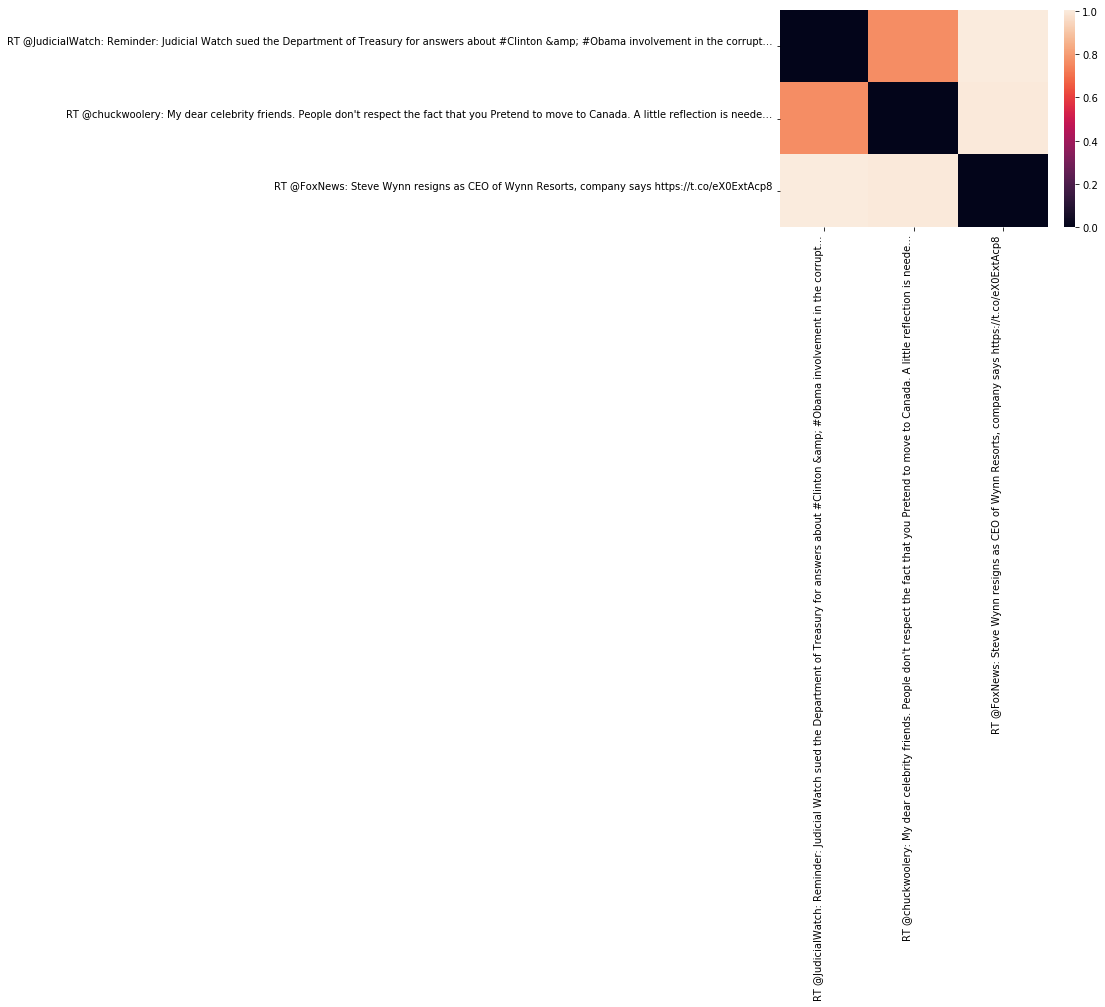

In [29]:
idxs = np.random.randint(len(tweets2), size=3)
visualize_dist(SVDt, tweets, idxs)

In [ ]:
# More bonus!
# Use one of the following pre-embedded models and see if your yelp scores improve? 
# What about your Twitter explorations?

# https://github.com/RaRe-Technologies/gensim-data